Мы поняли, что на количество перестановок больше влияет шум, чем тренд. Попробуем устранить шумовую компоненту ряда

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
from scipy.optimize import minimize, NonlinearConstraint, BFGS

In [2]:
import itertools as it

In [3]:
def count_permutationlist(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(len(df)-d+1):
        slice_df = df[i:i+d]
        sort_slice = sorted(slice_df)
        for j in range(d):
            slice_df[slice_df.index(sort_slice[j])] = j
        count_p[perm.index(tuple(slice_df))] += 1
    return count_p
def count_permutation(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            #print(slice_df[slice_df==sort_slice.iloc[j]])
            slice_df.replace(slice_df[slice_df==sort_slice.iloc[j]].item(), j, inplace = True)
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
    return count_p
def entropy(perm:list):
    allperm = sum(perm)
    ent = 0
    for i in range(len(perm)):
        probability = perm[i]/allperm
        if probability !=0:
            ent -= probability * math.log2(probability)
    return ent

In [4]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

In [13]:
def noise(X):
    def cons_f(x):
        f = 0
        for i in range(x.size):
            f += x[i]**2
        return [f]
    def cons_J(x):
        return x * 2
    def cons_H(x, v):
        f = v[0] * np.diag([2] * x.size)
        for i in range(1, x.size):
            f += v[i] * np.diag([2] * x.size)
        return f
    def F(x):
        Alp = [-4, 1, 6, 1, -4]
        f = 0
        for i in range(2,x.size-2):
            f += (Alp[0] * (X[i-2] - x[i-2]) + Alp[1] * (X[i-1] - x[i-1]) + Alp[2] * (X[i] - x[i]) + Alp[3] * (X[i+1] - x[i+1]) + Alp[4] * (X[i+2] - x[i+2]))**2
        return f
    def sol(X, t):
        for i in range(X.size):
            X[i][i] += t
        return X
    Xopt = X.copy()
    n = Xopt.size
    Alp = [-4, 1, 6, 1, -4]
    numerator = 0
    denominator = 0
    for i in range(2,n-2):
        numerator += (Alp[0] * Xopt[i-2] + Alp[1] * Xopt[i-1] + Alp[2] * Xopt[i] + Alp[3] * Xopt[i+1] + Alp[4] * Xopt[i+2])**2
        denominator += Alp[0]**2 + Alp[1]**2 + Alp[2]**2 + Alp[3]**2 + Alp[4]**2
    gam2 = numerator/denominator
    nonlinear_constraint = NonlinearConstraint(cons_f, n*gam2, n*gam2, jac=cons_J, hess=BFGS())
    s0 = np.array([gam2**0.5] * n)
    res = minimize(F, s0, method='SLSQP', jac='2-point',
                constraints=[nonlinear_constraint])
    return res        
    #TODO продолжить вычисления, доделать оптимизацию.
    
        
    

In [40]:
L = [ [0]*n for i in range(n) ]
    L[0][0] = Alp[2]
    L[0][1] = Alp[3]
    L[0][2] = Alp[4]
    L[1][0] = Alp[1]
    L[1][1] = Alp[2]
    L[1][2] = Alp[3]
    L[1][3] = Alp[4]
    for i in range(2,n-2):
        L[i][i-2] = Alp[0]
        L[i][i-1] = Alp[1]
        L[i][i] = Alp[2]
        L[i][i+1] = Alp[3]
        L[i][i+2] = Alp[4]
    L[n-2][n-4] = Alp[0]
    L[n-2][n-3] = Alp[1]
    L[n-2][n-2] = Alp[2]
    L[n-2][n-1] = Alp[3]
    L[n-1][n-3] = Alp[0]
    L[n-1][n-2] = Alp[1]
    L[n-1][n-1] = Alp[2]
    T = 1 #TODO
    LtL = np.array(L).dot(np.array(L).transpose)
    LtLy = LtL.dot(Xopt.to_numpy())
    LtLT = sol(LtL.copy(), t)
    s = np.linalg.solve(LtLT,LtLy)
    if s.dot(s.transpose()) > gam2:
        T *= 2
        LtLT1 = sol(LtL.copy(), t)
        s1 = np.linalg.solve(LtLT,LtLy)
        if s1.dot(s1.transpose()) > n * gam2:
            

IndentationError: unexpected indent (Temp/ipykernel_22264/3423934964.py, line 23)

<AxesSubplot:>

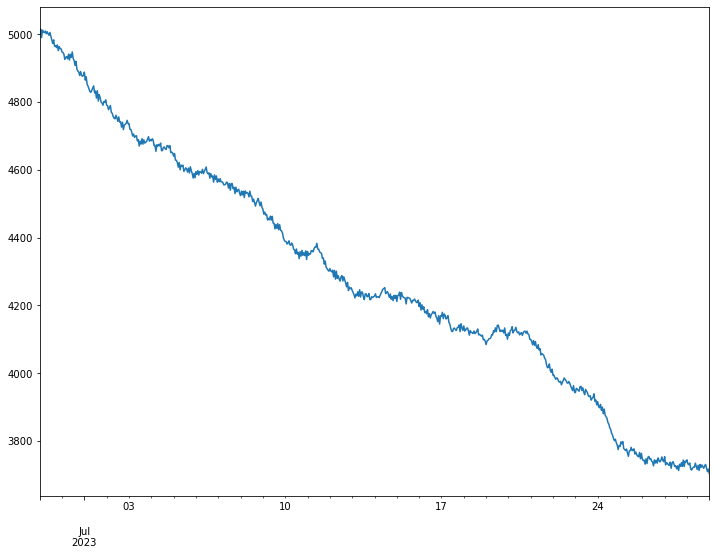

In [14]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0
ts = fun(datelist.copy(), 0.4501, 0.5483, 15, 2, 0)
ts.plot(figsize=(12,9))

In [15]:
s = noise(ts)

In [16]:
max(s)

22.505276056064602

In [17]:
l = 0
for i in range(s.size):
    l += s[i]**2
l

35920.643685184514

In [19]:
n = ts.size
Alp = [-4, 1, 6, 1, -4]
numerator = 0
denominator = 0
for i in range(2,n-2):
    numerator += (Alp[0] * ts[i-2] + Alp[1] * ts[i-1] + Alp[2] * ts[i] + Alp[3] * ts[i+1] + Alp[4] * ts[i+2])**2
    denominator += Alp[0]**2 + Alp[1]**2 + Alp[2]**2 + Alp[3]**2 + Alp[4]**2
gam2 = numerator/denominator
n*gam2

27605.233926895646

In [23]:
new_ts = ts - s

<AxesSubplot:>

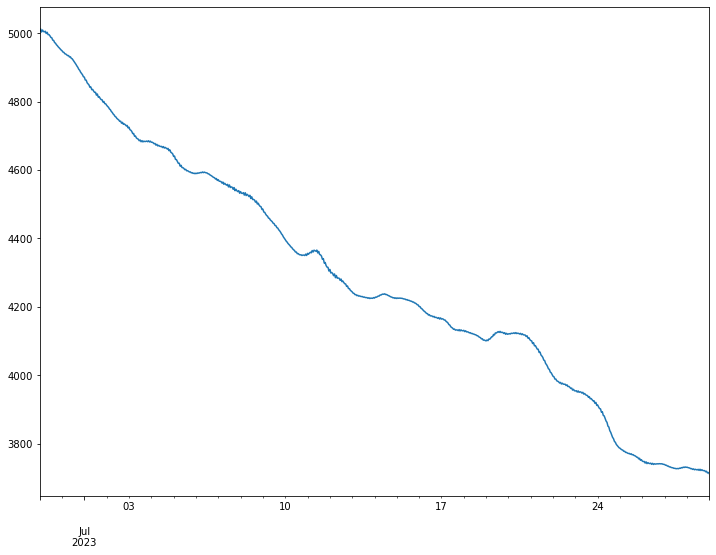

In [25]:
new_ts.plot(figsize=(12,9))

In [27]:
datelist['29/06/2023 00:00:00'] = 0.0
datelist['29/06/2023 01:00:00'] = 0.0
noise = fun(datelist.copy(), 0, 0, 15, 0, 0)

<AxesSubplot:>

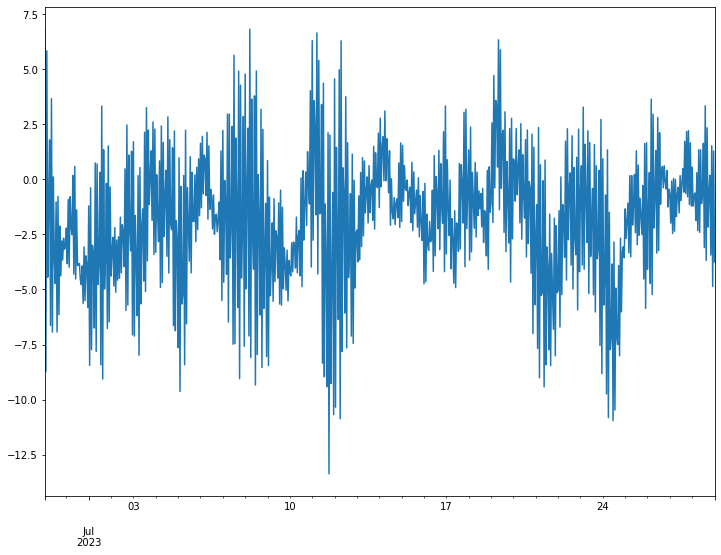

In [29]:
diff = new_ts.diff(periods=1).dropna()
diff.plot(figsize=(12,9))

In [30]:
for d in range(2,11):
    print("len of slice: ", d)
    c1 = count_permutationlist(new_ts.copy().tolist(), d)
    c = count_permutationlist(noise.copy().tolist(), d)
    c2 = count_permutationlist(diff.copy().tolist(), d)
    print("max entropy: ", math.log2(math.factorial(d)))
    print("noise entropy: ", entropy(c))
    print("ts entropy: ", entropy(c1))
    print("diff entropy: ", entropy(c2))
    

len of slice:  2
max entropy:  1.0
noise entropy:  0.9999109429180594
ts entropy:  0.8761378030396786
diff entropy:  0.9999874417092943
len of slice:  3
max entropy:  2.584962500721156
noise entropy:  2.5844870584641124
ts entropy:  2.0688112863957344
diff entropy:  2.464228561157289
len of slice:  4
max entropy:  4.584962500721156
noise entropy:  4.576415232814716
ts entropy:  3.2958479908105867
diff entropy:  3.638357879223464
len of slice:  5
max entropy:  6.906890595608519
noise entropy:  6.825526565874436
ts entropy:  4.235363607878263
diff entropy:  4.815212608105756
len of slice:  6
max entropy:  9.491853096329674
noise entropy:  8.686065472032052
ts entropy:  5.030632109719263
diff entropy:  6.1546164395119805
len of slice:  7
max entropy:  12.29920801838728
noise entropy:  9.357666721872626
ts entropy:  5.636357375581788
diff entropy:  7.306806880654855
len of slice:  8
max entropy:  15.29920801838728
noise entropy:  9.45176905954741
ts entropy:  6.160760645295201
diff entropy

Мы наблюдаем, что энтропия работаем после устранения шумовых компонент. Однако задача условной оптимизации ресурсозатратная и не дает быстро определить прогнозируемость ряда быстро.
Попробуем ариму на безшумовом ряде

In [31]:
test = sm.tsa.adfuller(new_ts)#ПРОСТО РЯД
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -1.4020842039664034
p-value:  0.5812765180601499
Critical values:  {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
есть единичные корни, ряд не стационарен


In [32]:
test = sm.tsa.adfuller(diff)#РЯД ПОСЛЕ ДИФЕРЕНЦИРОВАНИЯ
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.113494113811917
p-value:  0.0009199605278748325
Critical values:  {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}
единичных корней нет, ряд стационарен


In [33]:
m = diff.index[int(len(new_ts.index)/2+1)]
r1 = sm.stats.DescrStatsW(new_ts[m:])
r2 = sm.stats.DescrStatsW(new_ts[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  3.3006204262215204e-179


In [34]:
m = diff.index[int(len(diff.index)/2+1)]
r1 = sm.stats.DescrStatsW(diff[m:])
r2 = sm.stats.DescrStatsW(diff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.0032726958975424097


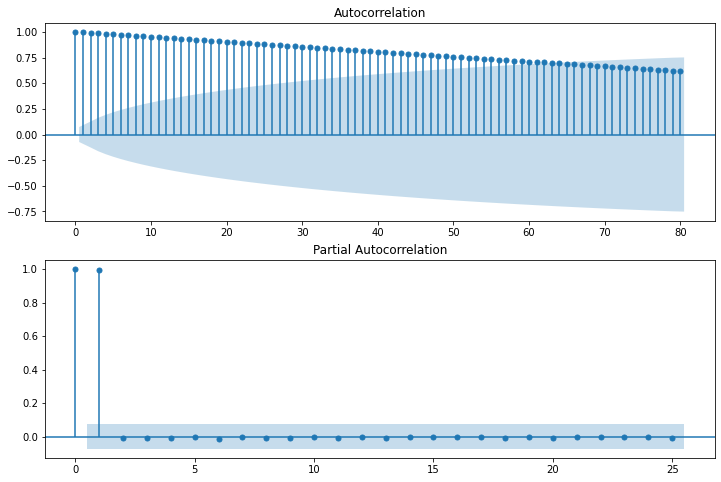

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(new_ts.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(new_ts, lags=25, ax=ax2)

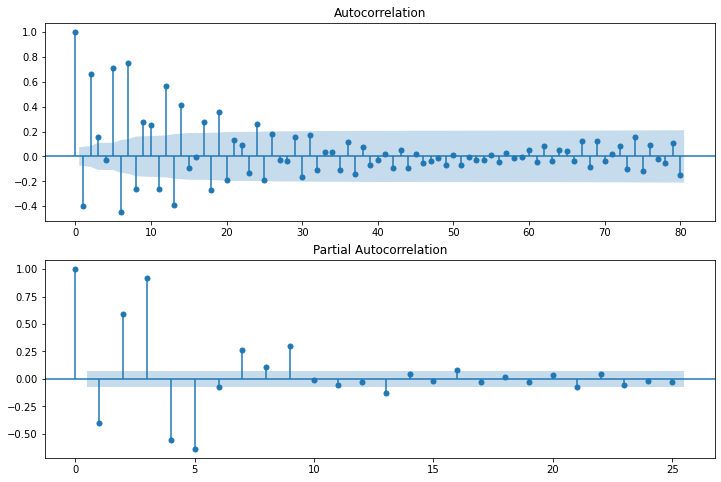

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=25, ax=ax2)

Мы видим, что арима "ломается", так как при устранении шума мы могли убрать и автокорреляционную компоненту. Попробуем сами подобрать коэфициенты

In [37]:
src_data_model = new_ts[:'2023-07-17 00:00:00']
src_data_model

2023-06-29 00:00:00    5005.261001
2023-06-29 01:00:00    5012.085808
2023-06-29 02:00:00    5003.353444
2023-06-29 03:00:00    5009.189433
2023-06-29 04:00:00    5004.741695
                          ...     
2023-07-16 20:00:00    4166.576794
2023-07-16 21:00:00    4168.735489
2023-07-16 22:00:00    4164.543829
2023-07-16 23:00:00    4167.874132
2023-07-17 00:00:00     4164.48796
Length: 433, dtype: object

In [51]:
model = sm.tsa.ARIMA(src_data_model.astype(float), order=(1,1,1)).fit()

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

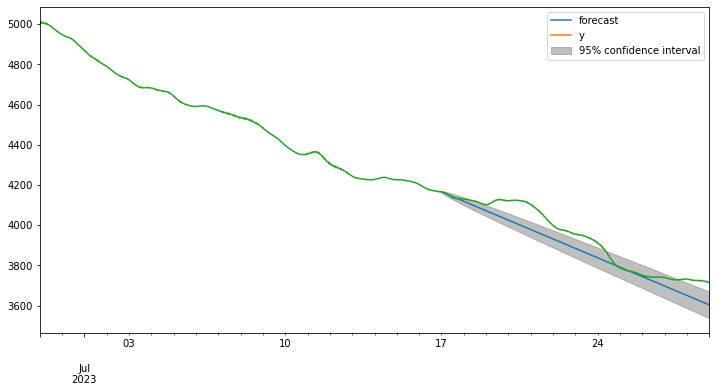

In [52]:
model.plot_predict('2023-07-17 00:00:00','2023-07-29 00:00:00')
new_ts.plot(figsize=(12,6))

Сравним с решением до устранения шума

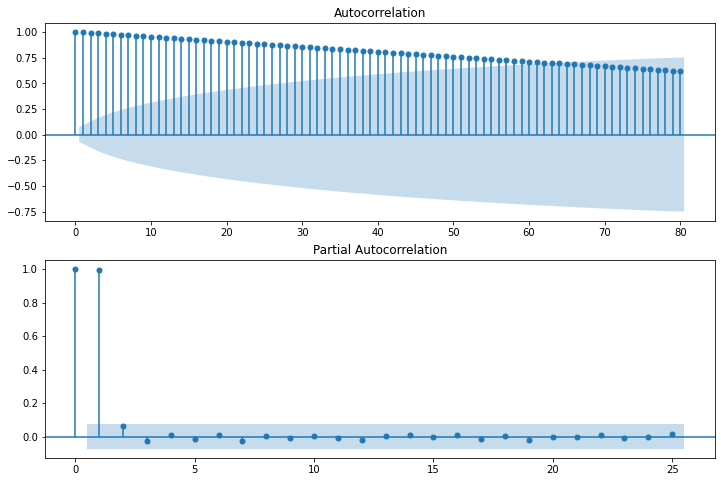

In [53]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=25, ax=ax2)

<AxesSubplot:>

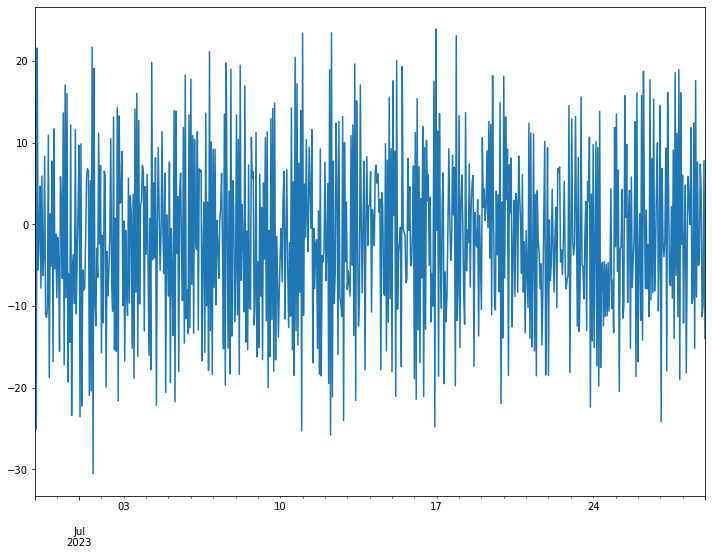

In [55]:
tsdiff = ts.diff(periods=1).dropna()
tsdiff.plot(figsize=(12,9))

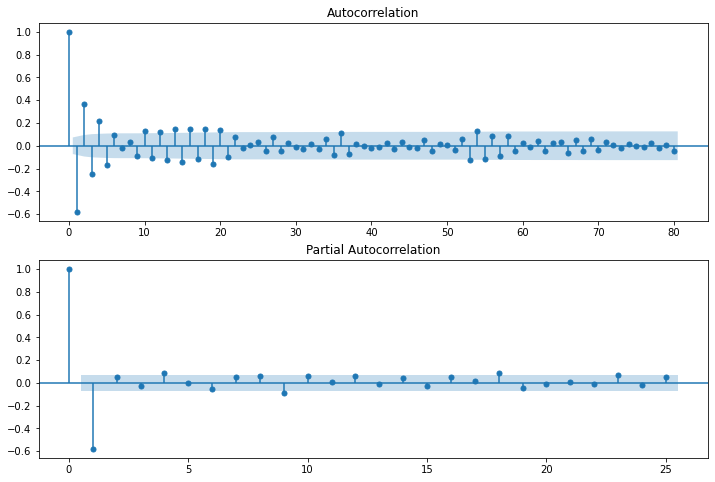

In [56]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tsdiff.values.squeeze(), lags=80, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tsdiff, lags=25, ax=ax2)

In [57]:
src_data_model1 = ts[:'2023-07-17 00:00:00']

In [63]:
model1 = sm.tsa.ARIMA(src_data_model1.astype(float), order=(1,1,1)).fit()

D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


D:\Programs\Anac\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:>

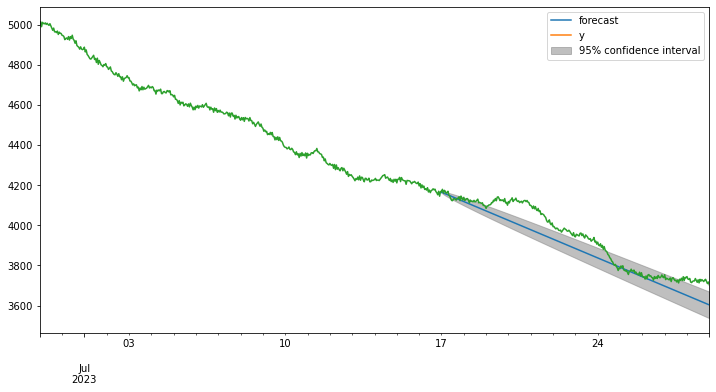

In [64]:
model1.plot_predict('2023-07-17 00:00:00','2023-07-29 00:00:00')
ts.plot(figsize=(12,6))